In [1]:
!pip install pandas scikit-learn matplotlib seaborn tqdm pytorch-pretrained-bert

In [ ]:
# ─── 셀 1: 필요한 라이브러리 설치 ─────────────────────────────────────────────
%pip install \
    pandas \
    scikit-learn \
    matplotlib \
    seaborn \
    tqdm \
    pytorch-pretrained-bert


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorch_pretrained_bert import BertTokenizer
import pandas as pd
import numpy as np
from torch.utils.data import *
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import random
from transformers import get_linear_schedule_with_warmup
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# (속도 조금 느려지지만) CuDNN 결정론 모드 활성화
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False

/home/kong/miniconda3/envs/urlbert-gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def dataPreprocessFromCSV(filename, input_ids, input_types, input_masks, label):
    """
    Preprocess data from a CSV file containing URLs and labels.

    :param filename: The path to the CSV data file.
    :param input_ids: List to store input char IDs.
    :param input_types: List to store segment IDs.
    :param input_masks: List to store attention masks.
    :param label: List to store labels.
    :return: None
    """
    pad_size = 512
    tokenizer = BertTokenizer("/home/kong/urlbert/url_bert/urlbert2/bert_tokenizer/vocab.txt")  # Initialize the tokenizer

    data = pd.read_csv(filename, encoding='utf-8')
    for i, row in tqdm(data.iterrows(), total=len(data)):
        x1 = row['text']  # Replace with the column name in your CSV file where the text data is located
        x1 = tokenizer.tokenize(x1)
        tokens = ["[CLS]"] + x1 + ["[SEP]"]

        # Get input_id, seg_id, att_mask
        ids = tokenizer.convert_tokens_to_ids(tokens)
        types = [0] * (len(ids))
        masks = [1] * len(ids)

        # Pad if short, truncate if long
        if len(ids) < pad_size:
            types = types + [1] * (pad_size - len(ids))  # Set segment to 1 for the masked part
            masks = masks + [0] * (pad_size - len(ids))
            ids = ids + [0] * (pad_size - len(ids))
        else:
            types = types[:pad_size]
            masks = masks[:pad_size]
            ids = ids[:pad_size]
        input_ids.append(ids)
        input_types.append(types)
        input_masks.append(masks)
        assert len(ids) == len(masks) == len(types) == pad_size

        y = row['label']
        if y == 'malicious':
            label.append([1])
        elif y == 'benign':
            label.append([0])
        elif y == "1":
            label.append([1])
        elif y == "0":
            label.append([0])

In [3]:
input_ids = []  # input char ids
input_types = []  # segment ids
input_masks = []  # attention mask
label = []

dataPreprocessFromCSV("/home/kong/urlbert/url_bert/urlbert2/dataset/urlbert_input.csv", input_ids, input_types, input_masks, label)

100%|██████████| 79998/79998 [00:45<00:00, 1755.43it/s]


In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [5]:
def spiltDatast_bert(input_ids, input_types, input_masks, label):
    """
    Split the dataset into training and testing sets.

    :param input_ids: List of input character IDs.
    :param input_types: List of segment IDs.
    :param input_masks: List of attention masks.
    :param label: List of labels.
    :return: Split datasets for training and testing.
    """
    # Randomly shuffle the indices
    random_order = list(range(len(input_ids)))
    np.random.seed(2024)  # Fix the seed
    np.random.shuffle(random_order)
    print(random_order[:10])

    # Split the dataset into 80% training and 20% testing
    input_ids_train = np.array([input_ids[i] for i in random_order[:int(len(input_ids) * 0.8)]])
    input_types_train = np.array([input_types[i] for i in random_order[:int(len(input_ids) * 0.8)]])
    input_masks_train = np.array([input_masks[i] for i in random_order[:int(len(input_ids) * 0.8)]])
    y_train = np.array([label[i] for i in random_order[:int(len(input_ids) * 0.8)]])
    print("input_ids_train.shape:" + str(input_ids_train.shape))
    print("input_types_train.shape:" + str(input_types_train.shape))
    print("input_masks_train.shape:" + str(input_masks_train.shape))
    print("y_train.shape:" + str(y_train.shape))

    input_ids_test = np.array([input_ids[i] for i in random_order[int(len(input_ids) * 0.8):int(len(input_ids) * 1)]])
    input_types_test = np.array([input_types[i] for i in random_order[int(len(input_ids) * 0.8):int(len(input_ids) * 1)]])
    input_masks_test = np.array([input_masks[i] for i in random_order[int(len(input_ids) * 0.8):int(len(input_ids) * 1)]])
    y_test = np.array([label[i] for i in random_order[int(len(input_ids) * 0.8):int(len(input_ids) * 1)]])
    print("input_ids_test.shape:" + str(input_ids_test.shape))
    print("input_types_test.shape:" + str(input_types_test.shape))
    print("input_masks_test.shape:" + str(input_masks_test.shape))
    print("y_test.shape:" + str(y_test.shape))

    return input_ids_train, input_types_train, input_masks_train, y_train, input_ids_test, input_types_test, input_masks_test, y_test

In [6]:
print(len(input_ids))
print(len(label))

79998
79998


In [7]:
input_ids_train, input_types_train, input_masks_train, y_train, input_ids_val, input_types_val, input_masks_val, y_val = spiltDatast_bert(
        input_ids, input_types, input_masks, label)
BATCH_SIZE = 64
train_data = TensorDataset(torch.tensor(input_ids_train).to(DEVICE),
                               torch.tensor(input_types_train).to(DEVICE),
                               torch.tensor(input_masks_train).to(DEVICE),
                               torch.tensor(y_train).to(DEVICE))
train_sampler = RandomSampler(
     train_data,
     generator=torch.Generator().manual_seed(SEED)
)
train_loader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

val_data = TensorDataset(torch.tensor(input_ids_val).to(DEVICE),
                              torch.tensor(input_types_val).to(DEVICE),
                              torch.tensor(input_masks_val).to(DEVICE),
                              torch.tensor(y_val).to(DEVICE))
val_sampler = SequentialSampler(val_data)
val_loader = DataLoader(val_data, sampler=val_sampler, batch_size=BATCH_SIZE)

[54744, 26671, 24586, 5189, 17246, 41963, 19535, 24723, 71407, 5982]
input_ids_train.shape:(63998, 512)
input_types_train.shape:(63998, 512)
input_masks_train.shape:(63998, 512)
y_train.shape:(63998, 1)
input_ids_test.shape:(16000, 512)
input_types_test.shape:(16000, 512)
input_masks_test.shape:(16000, 512)
y_test.shape:(16000, 1)


In [8]:
%pip install --upgrade transformers


Note: you may need to restart the kernel to use updated packages.


In [8]:
import transformers
print(transformers.__version__)


4.52.4


In [ ]:
# ─── 셀 0: torchvision 재설치 (CUDA 12.1용 휠)
%pip install --upgrade torchvision --index-url https://download.pytorch.org/whl/cu121


Looking in indexes: https://download.pytorch.org/whl/cu121
Note: you may need to restart the kernel to use updated packages.


In [9]:
from transformers import (
    AutoConfig,
    AutoModelForMaskedLM,
)

config_kwargs = {
    "cache_dir": None,
    "revision": 'main',
    "use_auth_token": None,
    "hidden_dropout_prob": 0.1,
    "vocab_size": 5000,
}

config = AutoConfig.from_pretrained("../../bert_config", **config_kwargs)
print(config)

bert_model = AutoModelForMaskedLM.from_config(
    config=config,
)
bert_model.resize_token_embeddings(config_kwargs["vocab_size"])
print(bert_model)

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.52.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 5000
}

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(5000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (l

In [10]:
bert_dict = torch.load("/home/kong/urlbert/url_bert/urlbert2/bert_model/urlBERT (1).pt", map_location=torch.device("cpu"))
bert_model.load_state_dict(bert_dict)

/tmp/ipykernel_1459478/3496471146.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bert_dict = torch.load("/home/kong/urlbert/url_bert/urlbert2/bert_model/urlBERT (1).pt"

<All keys matched successfully>

In [11]:
class BertForSequenceClassification(nn.Module):
    def __init__(self, bert, freeze=False):
        super(BertForSequenceClassification, self).__init__()
        self.bert = bert
        for name, param in self.bert.named_parameters():
            param.requires_grad = True
        self.dropout = nn.Dropout(p=0.1)
        self.classifier = nn.Linear(768, 2)

    def forward(self, x):
        context = x[0]
        types = x[1]
        mask = x[2]
        outputs = self.bert(context, attention_mask=mask, token_type_ids=types, output_hidden_states=True)
        hidden_states = outputs.hidden_states[-1][:,0,:]
        out = self.dropout(hidden_states)
        out = self.classifier(out)
        
        return out

In [12]:
model = BertForSequenceClassification(bert_model)
model.bert.cls = nn.Sequential()
model.to(DEVICE)

BertForSequenceClassification(
  (bert): BertForMaskedLM(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(5000, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=7

In [13]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-4)

In [14]:
NUM_EPOCHS = 5
num_training_steps = len(train_loader) * NUM_EPOCHS
num_warmup_steps   = int(0.1 * num_training_steps)  # 예: 전체 스텝의 10%를 웜업에
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps,
)

In [15]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (x1, x2, x3, y) in enumerate(train_loader):
        start_time = time.time()
        x1, x2, x3, y = x1.to(device), x2.to(device), x3.to(device), y.to(device)
        
        y_pred = model([x1, x2, x3])
        model.zero_grad()
        
        loss = F.cross_entropy(y_pred, y.squeeze())
        loss.backward()
        
        optimizer.step()
        scheduler.step() 
        if (batch_idx + 1) % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.2f}%)]\t Loss: {:.6f}'.format(epoch, (batch_idx + 1) * len(x1),
                                                                            len(train_loader.dataset),
                                                                            100. * batch_idx / len(train_loader),
                                                                            loss.item()))

In [16]:
def validation(model, device, test_loader):
    """
    Perform model validation on the test data.

    :param model: The model to be validated.
    :param device: The device to run validation on (e.g., CPU or GPU).
    :param test_loader: The data loader for test data.
    :return: A tuple containing accuracy, precision, recall, and F1 score.
    """
    model.eval()
    test_loss = 0.0
    y_true = []
    y_pred = []

    for batch_idx, (x1, x2, x3, y) in enumerate(test_loader):
        x1, x2, x3, y = x1.to(device), x2.to(device), x3.to(device), y.to(device)
        with torch.no_grad():
            y_ = model([x1, x2, x3])

        test_loss += F.cross_entropy(y_, y.squeeze()).item()

        pred = y_.max(-1, keepdim=True)[1]  # .max(): 2 outputs, representing the maximum value and its index

        y_true.extend(y.cpu().numpy())
        y_pred.extend(pred.cpu().numpy())

    test_loss /= len(test_loader)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['benign', 'malware'],
                yticklabels=['benign', 'malware'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

    # Save the confusion matrix plot
    plt.savefig('confusion_matrix.png')

    print('Test set: Average loss: {:.4f}, Accuracy: {:.2f}%, Precision: {:.2f}%, Recall: {:.2f}%, F1: {:.2f}%'.format(
        test_loss, accuracy * 100, precision * 100, recall * 100, f1 * 100))

    return accuracy, precision, recall, f1

In [17]:
torch.cuda.empty_cache()

Train Epoch: 1 [6400/63998 (9.90%)]	 Loss: 0.071080
Train Epoch: 1 [12800/63998 (19.90%)]	 Loss: 0.062569
Train Epoch: 1 [19200/63998 (29.90%)]	 Loss: 0.012635
Train Epoch: 1 [25600/63998 (39.90%)]	 Loss: 0.192735
Train Epoch: 1 [32000/63998 (49.90%)]	 Loss: 0.079521
Train Epoch: 1 [38400/63998 (59.90%)]	 Loss: 0.027811
Train Epoch: 1 [44800/63998 (69.90%)]	 Loss: 0.122378
Train Epoch: 1 [51200/63998 (79.90%)]	 Loss: 0.003311
Train Epoch: 1 [57600/63998 (89.90%)]	 Loss: 0.004472
Train Epoch: 1 [62000/63998 (99.90%)]	 Loss: 0.044992
Test set: Average loss: 0.0305, Accuracy: 99.04%, Precision: 98.44%, Recall: 99.68%, F1: 99.05%
acc is: 0.9904, best acc is 0.9904
CUDA 메모리 부족 오류 발생! 최적 성능 모델을 저장하고 종료합니다.


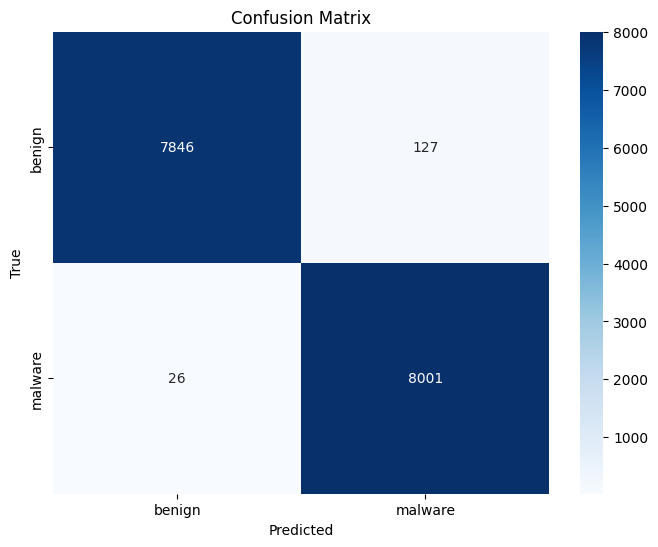

In [18]:


best_acc = 0.0
PATH = './checkpoints/modelx_URLBERT_80.pth'

try:
    for epoch in range(1, NUM_EPOCHS + 1):
        train(model, DEVICE, train_loader, optimizer, epoch)
        acc, precision, recall, f1 = validation(model, DEVICE, val_loader)

        if best_acc < acc:
            best_acc = acc
            torch.save(model.state_dict(), PATH)
        
        print("acc is: {:.4f}, best acc is {:.4f}".format(acc, best_acc))

        # GPU 캐시 메모리 비우기
        torch.cuda.empty_cache()

except RuntimeError as e:
    if "out of memory" in str(e).lower():
        print("CUDA 메모리 부족 오류 발생! 최적 성능 모델을 저장하고 종료합니다.")
        # (이미 best model은 저장되어 있음)
    else:
        raise  # 다른 에러는 그대로 다시 raise

    

/tmp/ipykernel_1459478/3622101841.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(PATH, map_location=DEVICE))
100%|██████████| 20000/200

Test set: Average loss: 0.0288, Accuracy: 99.10%, Precision: 98.54%, Recall: 99.68%, F1: 99.11%
[Test] Acc: 0.9910, Prec: 0.9854, Rec: 0.9968, F1: 0.9911


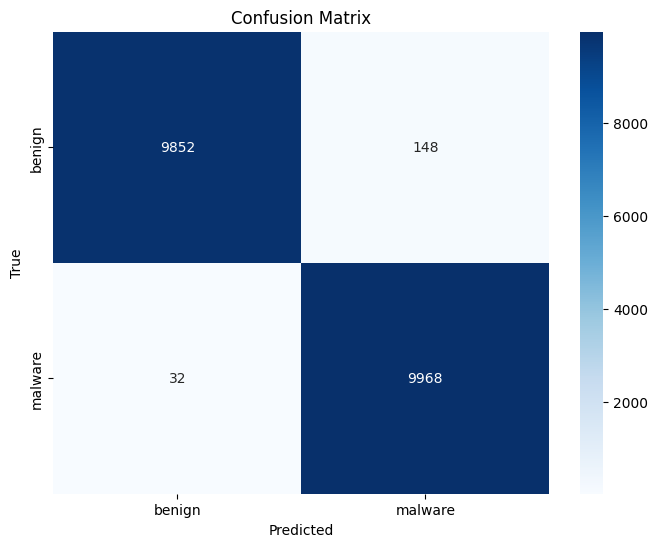

In [20]:


# 1) 저장된 최종 모델 불러오기
model.load_state_dict(torch.load(PATH, map_location=DEVICE))
model.to(DEVICE).eval()

# 2) 테스트 데이터 전처리
test_input_ids, test_input_types, test_input_masks, test_labels = [], [], [], []
dataPreprocessFromCSV(
    "/home/kong/urlbert/url_bert/urlbert2/dataset/urlbert_input_test.csv",
    test_input_ids, test_input_types, test_input_masks, test_labels
)

# 3) TensorDataset & DataLoader
test_dataset = TensorDataset(
    torch.tensor(test_input_ids).to(DEVICE),
    torch.tensor(test_input_types).to(DEVICE),
    torch.tensor(test_input_masks).to(DEVICE),
    torch.tensor(test_labels).to(DEVICE),
)
test_loader = DataLoader(test_dataset, batch_size=32)

# 4) validation() 함수로 테스트셋 평가
test_acc, test_prec, test_rec, test_f1 = validation(model, DEVICE, test_loader)
print(f"[Test] Acc: {test_acc:.4f}, Prec: {test_prec:.4f}, Rec: {test_rec:.4f}, F1: {test_f1:.4f}")
